In [2]:
import helper
import self_modelling_experiment_execution
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import random
import sys
import json

In [7]:
N = 100
population_size = 200
generations = 1_000
function_calls = population_size * generations

seed_weights  = 0
seed_states  = 1

weights = helper.init_weighted_max_sat_weights(N,seed_weights)
states = helper.init_weighted_max_sat_states(N,seed_states)

hyperparameters_dir = '../experiments/weighted_max_2_sat/hyperparameters/'

In [4]:
def read_file_results(file):
    results_dict = dict()
    with open(file,'r') as f:
        results_dict = json.load(f)
    return results_dict

# List of filepaths of FILES inside a directory
def get_filepaths(directory):
    files = [os.path.join(directory,f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory,f))]
    return files

def is_subset(d1,d2):
    if d1 == d2:
        return True
    for k in d1.keys():
        if k not in d2:
            return False
        if d1[k] != d2[k]:
            return False
    return True

# prefix: Files to collect results
# parameters: The parameters of the collected results
# Return a dictionary mapping filepath to results
def read_directory_results(directory,prefix,parameters):
    results = {}
    files = get_filepaths(directory)
    for file_path in files:
        if not prefix in file_path:
            continue
        file_results = read_file_results(file_path)
        file_parameters = file_results['parameters']
        if is_subset(parameters,file_parameters):
            results[file_path] = file_results
    return results

def learning_rates_from_directory(directory,prefix):
    learning_rates = set()
    files = get_filepaths(directory)
    for file_path in files:
        if not prefix in file_path:
            continue
        file_results = read_file_results(file_path)
        file_parameters = file_results['parameters']
        learning_rate = file_parameters['learning_rate']
        learning_rates.add(learning_rate)
    learning_rates = list(learning_rates)
    learning_rates.sort()
    return learning_rates

def get_self_modelling_function_call_energies(results):
    energies = [r['relaxation_energies'] for r in results.values()]
    energies = np.array(energies)
    number_runs = energies.shape[0]
    energies = energies.reshape((number_runs,-1))
    return energies

def get_state_updates(relaxations):
    assert (function_calls % relaxations == 0)
    state_updates = int(function_calls / relaxations)
    return state_updates

def run_self_modelling(number_runs,relaxations,hebbian_learning_relaxation,learning_rate):
    state_updates = get_state_updates(relaxations)
    print('Relaxations,State Updates:',relaxations,state_updates)
    energies = []
    for i in range(number_runs):
        model = self_modelling_experiment_execution.HopfieldNetworkRC(N,seed_weights,seed_states)
        relaxation_energies, relaxation_times = model.run(relaxations,state_updates,hebbian_learning_relaxation,learning_rate)
        relaxation_energies  = np.array(relaxation_energies).reshape(-1)
        energies.append(relaxation_energies)
    energies = np.array(energies)
    return energies

def learning_rate_energies(number_runs,relaxations,hebbian_learning_relaxation,learning_rates):
    energies = {}
    for learning_rate in learning_rates:
        print('Learning Rate:',learning_rate)
        learning_rate_energies = run_self_modelling(number_runs,relaxations,hebbian_learning_relaxation,learning_rate)
        minimum_energy = np.min(learning_rate_energies)
        print('Best Energy Found',minimum_energy)
        energies[learning_rate] = learning_rate_energies
    return energies

def print_file_params(dir):
    for file in get_filepaths(dir):
        if not 'self_modelling' in file:
            continue
        results = read_file_results(file)
        parameters = results['parameters']
        print(file,parameters)

In [8]:
relaxations = 4
state_updates =  50_000
learning_rate = 10 ** -12

In [9]:
self_modelling_no_learning_energies_file = 'self_modelling_no_learning_energies_4_relaxations.npy'
self_modelling_no_learning_energies = np.load(self_modelling_no_learning_energies_file)
self_modelling_no_learning_energies.shape

(50, 200000)

In [10]:
self_modelling_learning_rate_energies_file = 'self_modelling_learning_energies_4_relaxations.json'
with open(self_modelling_learning_rate_energies_file,'r') as file:
    self_modelling_learning_rate_energies = json.load(file)
    self_modelling_learning_rate_energies = {float(k):v for k,v in self_modelling_learning_rate_energies.items()}
self_modelling_learning_rate_energies.keys()

dict_keys([1e-10, 8.9e-11, 7.8e-11, 6.7e-11, 5.6e-11, 4.5e-11, 3.4e-11, 2.2999999999999998e-11, 1.1999999999999997e-11, 1e-12])

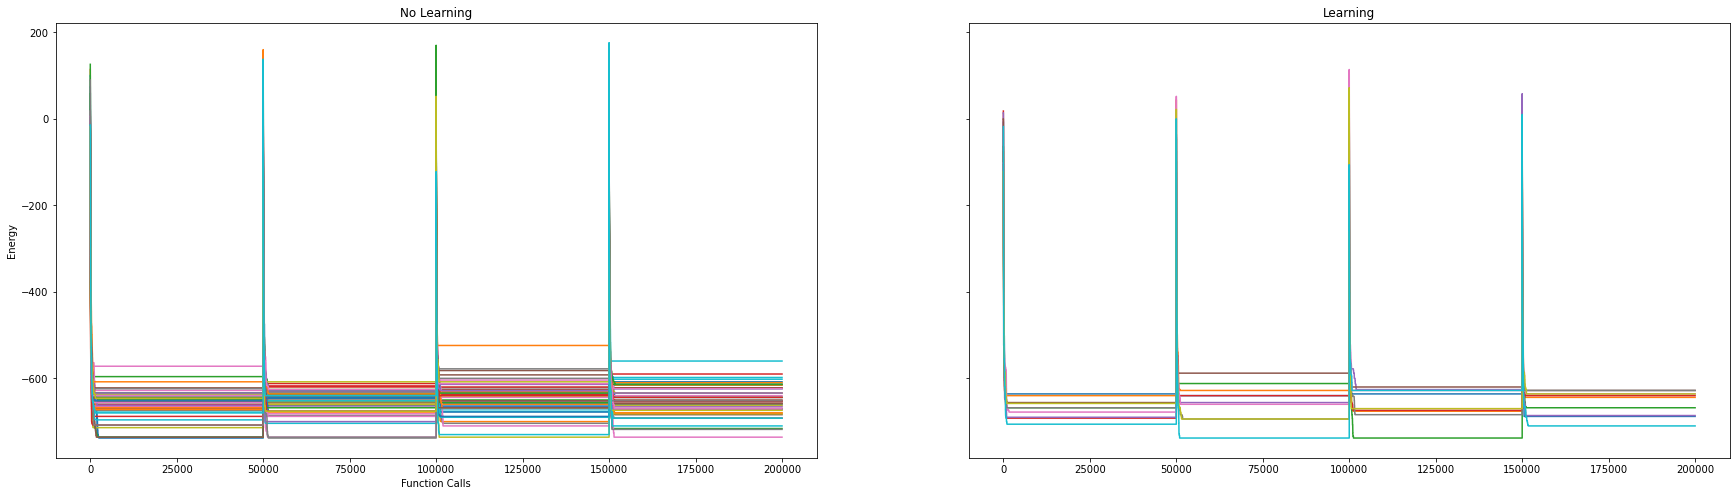

In [12]:
# Function Call Energy Plot
learning_energies = np.array(self_modelling_learning_rate_energies[learning_rate])
no_learning_energies = self_modelling_no_learning_energies
average_learning_run = np.mean(learning_energies,axis=0)
average_no_learning_run = np.mean(no_learning_energies,axis=0)
fcalls = learning_energies.shape[1]

fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(15*2,8))
ax0,ax1 = axs
x = range(1,fcalls+1)

ax0.plot(x,no_learning_energies.T)
ax0.set_xlabel('Function Calls')
ax0.set_ylabel('Energy')
ax0.set_title('No Learning')

ax1.plot(x,learning_energies.T)
ax1.set_title('Learning')

plt.show()

(50, 200000)
[10, 17] [49]


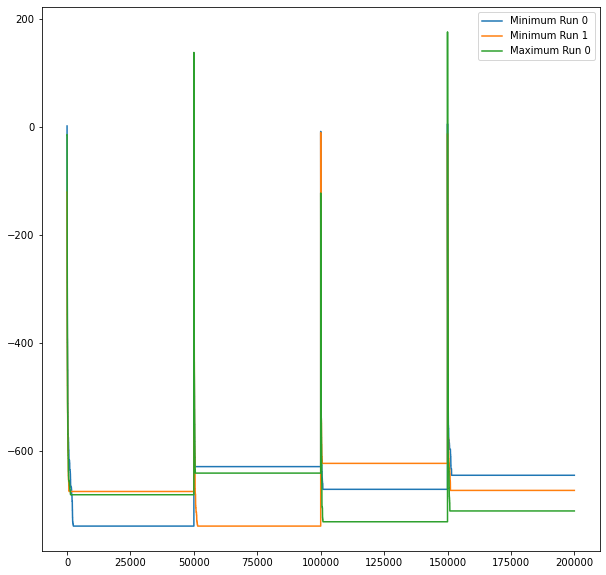

In [28]:
x = self_modelling_no_learning_energies
print(x.shape)

maximum_energy = np.max(x)
minimum_energy = np.min(x)
run_minimum_energies = []
run_maximum_energies = []

for i,run_e in enumerate(x):
    if np.min(run_e) == minimum_energy:
        run_minimum_energies.append(i)
    if np.max(run_e) == maximum_energy:
        run_maximum_energies.append(i)

print(run_minimum_energies, run_maximum_energies)

fig,ax = plt.subplots(figsize=(10,10))

for i, run_idx in enumerate(run_minimum_energies):
    y = x[run_idx]
    label= f'Minimum Run {i}'
    ax.plot(y,label=label)

for i,run_idx in enumerate(run_maximum_energies):
    y = x[run_idx]
    label=f'Maximum Run {i}'
    ax.plot(y,label=label)

ax.legend()
plt.show()